In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import itertools
import joblib

In [2]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")
df.head()
df.describe()


,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
count,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04,91379.000000,91379.000000,91379.000000,...,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000
mean,6.769458,11.619098,9.553919,10.032760,9.076251,3297.930328,7.850005e+10,27.065979,28.417120,25.717089,...,13.166020,11.904558,11.373193,32986.417484,34636.684647,31331.618978,89.043304,0.739065,1.851020,0.702242
std,3.903843,3.438873,5.858577,6.162798,5.575927,1224.305893,5.000027e+09,72.134023,75.761896,68.595239,...,9.589755,8.694028,6.942229,24713.874445,25978.845228,23497.873065,26.415610,0.871314,1.762698,0.828796
min,0.788363,0.027142,1.141556,1.238270,1.049744,2012.000148,7.350000e+10,0.000000,0.000000,0.000000,...,-6.693373,-7.270075,0.000000,10.151990,11.029667,9.484346,0.000000,0.000000,0.000000,0.000000
25%,3.473063,10.829331,4.958993,5.205861,4.709511,2019.431812,7.350000e+10,0.000000,0.000000,0.000000,...,4.905387,4.438425,5.000000,11158.598400,11721.447542,10588.793237,82.976727,0.076749,0.512667,0.072912
50%,6.336167,11.856560,6.870737,7.205499,6.524046,2959.863686,8.350000e+10,0.000000,0.000000,0.000000,...,10.803943,9.774467,11.000000,26378.636210,27686.214032,25047.188462,90.867362,0.437995,1.323101,0.416274
75%,8.664984,12.847944,14.049470,14.782679,13.379256,4820.890157,8.350000e+10,16.947618,17.775980,16.038090,...,22.470382,20.322434,17.000000,53493.821285,56092.212376,50797.690402,98.482652,1.088621,2.681788,1.036574
max,32.455222,46.893150,24.790883,26.407305,24.268431,4827.999971,8.350000e+10,1621.001906,1753.747866,1500.666382,...,40.771383,36.724191,23.000000,75004.999150,82503.130084,74999.343414,360.000000,7.799086,16.421115,7.252319


In [3]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()


68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

In [4]:
#stratified sampling trainset
X_synop_0 = X_train[X_train['SYNOPCode'] == 0]
y_synop_0_FSO = y_FSO_train[X_synop_0.index]
y_synop_0_RFL = y_RFL_train[X_synop_0.index]
# group trainset by Distance, time and Frequency
# create an empty list to save sample
sampled_X = []
sampled_y_FSO = []
sampled_y_RFL = []
#stratified sampling X
sampled_X=X_synop_0.groupby(['Distance','Frequency','Time'], group_keys=False).apply(
    lambda group:group.sample(n=min(5, len(group)), random_state=42)
)
#make Y correspond to X
sampled_y_FSO=y_synop_0_FSO.loc[sampled_X.index]
sampled_y_RFL=y_synop_0_RFL.loc[sampled_X.index]
#delete synop_0 data in the trainset
X_no_synop_0 = X_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_FSO_no_synop_0 = y_FSO_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_RFL_no_synop_0 = y_RFL_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
#merge data with deleted trainest and sampled synop_0 trainset data
X_combined = pd.concat([X_no_synop_0, sampled_X], ignore_index=True)
y_FSO_combined = pd.concat([y_FSO_no_synop_0, sampled_y_FSO], ignore_index=True)
y_RFL_combined = pd.concat([y_RFL_no_synop_0, sampled_y_RFL], ignore_index=True)
#redistribute data
combined = pd.concat([X_combined, y_FSO_combined, y_RFL_combined], axis=1)
shuffled_combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = shuffled_combined.iloc[:, :-2]
y_FSO_train = shuffled_combined.iloc[:, -2]
y_RFL_train = shuffled_combined.iloc[:, -1]

In [5]:
#Function to generate dataset for each model
def g_dataset(df,vars):
    dataset=pd.DataFrame()
    for var in vars:
        dataset[var]=df[var]
    return dataset
variables = {
    'Overall_FSO_Att': ['Time','TemperatureMin','Particulate','AbsoluteHumidity','VisibilityMin','ParticulateMin','Temperature','Visibility','Distance'],
    'Overall_RFL_Att': ['Visibility','RainIntensityMin','Temperature','RainIntensityMax','Distance','RainIntensity','AbsoluteHumidity']
}

In [6]:
# #Prepare RFL trainset for FSO-RFL hybrid model
print(X_train.shape)
overall_fso = RandomForestRegressor(max_depth= 31, max_features='sqrt', min_samples_leaf= 1, min_samples_split= 3, n_estimators= 161,n_jobs=7)
X_train_fso_rf1=g_dataset(X_train,variables['Overall_FSO_Att'])
overall_fso.fit(X_train_fso_rf1,y_FSO_train)
joblib.dump(overall_fso, "Overall_FSO_Att.joblib")

#Fitting FSO model
FSO_pred=overall_fso.predict(g_dataset(X,variables['Overall_FSO_Att']))
print(FSO_pred.shape)
#add FSO_pred into RFL trainset
X_train_RFL=X.copy()
X_train_RFL['FSO_pred']=FSO_pred
print(X_train_RFL)




(73103, 25)
(91379,)
       AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
0             17.595709            17.615907            17.340148   
1             17.549693            17.572415            17.299439   
2             17.290230            17.644014            16.037894   
3             16.820880            17.066776            15.895622   
4             16.813820            17.953974            15.227225   
...                 ...                  ...                  ...   
91374         23.283256            24.142871            22.169805   
91375         23.259618            25.104895            21.005496   
91376         23.331697            23.996130            22.148649   
91377         21.241027            21.624932            20.736391   
91378         20.876100            22.581643            19.785652   

          Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
0      2115.338398  83500000000     0.000000        0.000000        0.

In [7]:
#Prepare FSO trainset for RFL-FSO hybrid model
overall_rfl = RandomForestRegressor(max_depth= 23, max_features= 'sqrt', min_samples_leaf=1, min_samples_split=3, n_estimators= 233,n_jobs=7)
X_train_rfl_rf1=g_dataset(X_train,variables['Overall_RFL_Att'])
overall_rfl.fit(X_train_rfl_rf1,y_RFL_train)
joblib.dump(overall_rfl, "Overall_RFL_Att.joblib")

#Fitting RFL model
RFL_pred=overall_rfl.predict(g_dataset(X,variables['Overall_RFL_Att']))
print(RFL_pred.shape)
#add RFL_pred into FSO trainset
X_train_FSO=X.copy()
X_train_FSO['RFL_pred']=RFL_pred
print(X_train_FSO)

(91379,)
       AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
0             17.595709            17.615907            17.340148   
1             17.549693            17.572415            17.299439   
2             17.290230            17.644014            16.037894   
3             16.820880            17.066776            15.895622   
4             16.813820            17.953974            15.227225   
...                 ...                  ...                  ...   
91374         23.283256            24.142871            22.169805   
91375         23.259618            25.104895            21.005496   
91376         23.331697            23.996130            22.148649   
91377         21.241027            21.624932            20.736391   
91378         20.876100            22.581643            19.785652   

          Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
0      2115.338398  83500000000     0.000000        0.000000        0.000000   
1 

In [8]:
# #define feature selection function
def fs(X, y):
    # Initialize S as the set of all predictor variables
    features = X.columns.tolist()
    #  Initialize an empty table R
    result_table = pd.DataFrame(columns=['feature', 'RMSE', 'R2_score'])
    print('----start training----')
    while features:
        # Train a random forest with the current set of features
        rf = RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=7)
        rf.fit(X[features], y)
        
        # Calculate RMSE and R2 for the current random forest
        y_pred = rf.predict(X[features])
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        
        # Rank importance and find the least important feature
        importance = rf.feature_importances_
        importance_df = pd.DataFrame({'feature': features, 'importance': importance})
        importance_df = importance_df.sort_values(by='importance', ascending=True)
        least_important_feature = importance_df.iloc[0]['feature']
        
        # Remove the least important feature from S and log the results
        features.remove(least_important_feature)
        Feature_info = pd.DataFrame([{
            'feature': least_important_feature,
            'RMSE': rmse,
            'R2_score': r2
        }])

        # Concatenate the new row to the result table
        result_table = pd.concat([result_table, Feature_info], ignore_index=True)
        
        # Display progress
        tqdm.write(f"Removed: {least_important_feature}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    return result_table

In [9]:
#define plot function
def plot_results(results,Type):
    # Extract data from result_RFL
    features = results['feature']
    rmse_values = results['RMSE']
    r2_values = results['R2_score']

    # Create the figure and subplots
    fig,ax1 = plt.subplots( figsize=(10, 6), sharex=False)

    # Plotting result
    ax1.plot(features, rmse_values, color='blue', marker='o', label='RMSE')
    ax1.set_xlabel('Features',fontsize=14)
    ax1.set_ylabel('RMSE', color='blue',fontsize=14)
    ax1.tick_params(axis='x', rotation=90)
    ax1.grid(True)

    # Second y-axis for R² in result
    ax1_twin = ax1.twinx()
    ax1_twin.plot(features, r2_values, color='red', marker='x', label='R²')
    ax1_twin.set_ylabel('R²', color='red',fontsize=14)
    ax1_twin.tick_params(axis='y', colors='red')
    if Type=='RFL':
        ax1.set_title('RFL model Feature Importance Analysis',fontsize=14)
    else:
        ax1.set_title('FSO model Feature Importance Analysis',fontsize=14)
    plt.tight_layout()

    # Show the combined plot
    plt.show()


In [10]:
def process(Type):
    if Type=='RFL':
        result_RFL = fs(X_train_RFL, y_RFL)
        return result_RFL
    else:
        result_FSO = fs(X_train_FSO, y_FSO)
        return result_FSO

In [11]:
g_result_RFL=process('RFL')

----start training----
Removed: WindDirection, RMSE: 0.1781, R2: 0.9973
Removed: WindSpeed, RMSE: 0.1764, R2: 0.9974
Removed: Particulate, RMSE: 0.1762, R2: 0.9974
Removed: WindSpeedMin, RMSE: 0.1773, R2: 0.9973
Removed: WindSpeedMax, RMSE: 0.1774, R2: 0.9973
Removed: AbsoluteHumidityMin, RMSE: 0.1776, R2: 0.9973
Removed: VisibilityMax, RMSE: 0.1735, R2: 0.9975
Removed: AbsoluteHumidityMax, RMSE: 0.1732, R2: 0.9975
Removed: ParticulateMin, RMSE: 0.1711, R2: 0.9975
Removed: VisibilityMin, RMSE: 0.1709, R2: 0.9975
Removed: TemperatureDifference, RMSE: 0.1714, R2: 0.9975
Removed: Time, RMSE: 0.1796, R2: 0.9973
Removed: Frequency, RMSE: 0.1975, R2: 0.9967
Removed: ParticulateMax, RMSE: 0.2588, R2: 0.9943
Removed: RelativeHumidity, RMSE: 0.2592, R2: 0.9943
Removed: TemperatureMax, RMSE: 0.2633, R2: 0.9941
Removed: Visibility, RMSE: 0.2620, R2: 0.9942
Removed: SYNOPCode, RMSE: 0.2781, R2: 0.9935
Removed: TemperatureMin, RMSE: 0.2802, R2: 0.9934
Removed: RainIntensityMin, RMSE: 0.2782, R2: 0.

In [12]:
g_result_FSO=process('FSO')

----start training----
Removed: Frequency, RMSE: 0.2879, R2: 0.9946
Removed: RainIntensityMin, RMSE: 0.2874, R2: 0.9946
Removed: RainIntensity, RMSE: 0.2874, R2: 0.9946
Removed: SYNOPCode, RMSE: 0.2873, R2: 0.9946
Removed: WindDirection, RMSE: 0.2881, R2: 0.9946
Removed: RainIntensityMax, RMSE: 0.2845, R2: 0.9947
Removed: WindSpeedMin, RMSE: 0.2844, R2: 0.9947
Removed: AbsoluteHumidityMin, RMSE: 0.2838, R2: 0.9947
Removed: AbsoluteHumidityMax, RMSE: 0.2817, R2: 0.9948
Removed: WindSpeed, RMSE: 0.2791, R2: 0.9949
Removed: WindSpeedMax, RMSE: 0.2840, R2: 0.9947
Removed: TemperatureMax, RMSE: 0.2906, R2: 0.9945
Removed: TemperatureDifference, RMSE: 0.2886, R2: 0.9945
Removed: VisibilityMax, RMSE: 0.3146, R2: 0.9935
Removed: ParticulateMax, RMSE: 0.3133, R2: 0.9936
Removed: RelativeHumidity, RMSE: 0.3127, R2: 0.9936
Removed: Time, RMSE: 0.3128, R2: 0.9936
Removed: TemperatureMin, RMSE: 0.3914, R2: 0.9899
Removed: AbsoluteHumidity, RMSE: 0.3879, R2: 0.9901
Removed: Particulate, RMSE: 0.4423

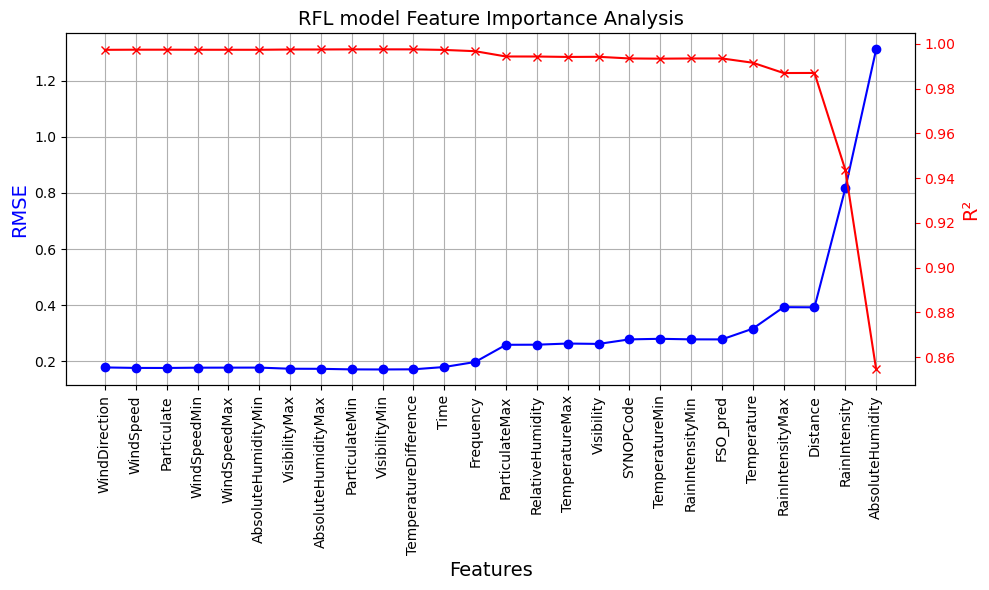

In [13]:
plot_results(g_result_RFL,'RFL')

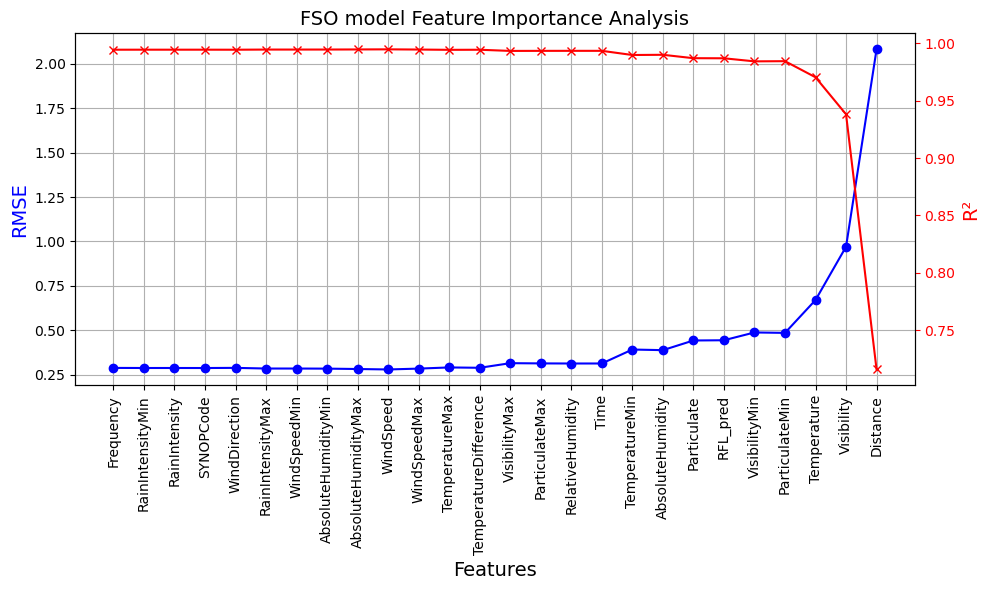

In [14]:
plot_results(g_result_FSO,'FSO')